<div>
Olá, Pedro!

Meu nome é Luiz. Fico feliz em revisar seu projeto. Ao longo do texto farei algumas observações sobre melhorias no código e também farei comentários sobre suas percepções sobre o assunto. Estarei aberto a feedbacks e discussões sobre o tema.

**Peço que mantenha e não altere os comentários que eu fizer por aqui para que possamos nos localizar posteriormente, ok?**

Mais uma coisa, vamos utilizar um código de cores para você entender o meu feedback no seu notebook. Funciona assim:

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Sucesso. Tudo foi feito corretamente.
</div>

<div class="alert alert-block alert-warning">
<b>Comentário do revisor: </b> <a class="tocSkip"></a>

Alerta não crítico, mas que pode ser corrigido para melhoria geral no seu código/análise.
</div>

<div class="alert alert-block alert-danger">

<b>Comentário do revisor: </b> <a class="tocSkip"></a>
    
Erro que precisa ser arrumado, caso contrário seu projeto **não** será aceito.
</div>

Você pode interagir comigo através dessa célula:
<div class="alert alert-block alert-info">
<b>Resposta do Aluno.</b> <a class="tocSkip"></a>
</div>

<div class="alert alert-block alert-danger">
<b> Comentário geral do revisor v1</b> <a class="tocSkip"></a>
<s>
    
Obrigado por enviar o seu projeto e pelo esforço de chegar até aqui. O seu projeto possui alguns pontos bem interessantes, dos quais eu destaco:
    
- Código bem simples e estruturado 
- Comentários sucintos e bem objetivos
    
Entretanto, deixei alguns comentários em alguns trechos que precisam de ajuste. Peço que trabalhe nesses pontos para avançarmos.
    
Qualquer dúvida, pode contar comigo.   
    
    
**Até breve!**
</s>
</div>

<div class="alert alert-block alert-success">
<b> Comentário geral do revisor</b> <a class="tocSkip"></a>

Obrigado por enviar o seu projeto e fazer os ajustes sugeridos. Essa versão do seu trabalho ficou muito melhor! Espero que as sugestões sejam relevantes para projetos futuros.
    
<br>
Te desejo uma jornada de muito sucesso e aprendizado.
    
<br>   
    
Qualquer dúvida, pode contar comigo.   
    
<br>  
    
**Até breve!**

</div>

O serviço de vendas de carros usados Rusty Bargain está desenvolvendo um aplicativo para atrair novos clientes. Nesse aplicativo, você pode descobrir rapidamente o valor de mercado do seu carro. Você tem acesso a dados históricos: especificações técnicas, versões de acabamento e preços. Você precisa construir o modelo para determinar o valor. 

Rusty Bargain está interessado em:

- a qualidade da predição;
- a velocidade da predição;
- o tempo necessário para o treinamento

## Abstract

Este projeto tem como objetivo prever o **preço de carros usados** com base em informações históricas e características dos veículos, utilizando técnicas de **Machine Learning supervisionado**.  
Após o tratamento dos dados e a criação de um pipeline de pré-processamento, diferentes modelos foram testados — incluindo **Regressão Linear**, **Ridge**, **Decision Tree** e **Random Forest**.  

Os resultados mostraram que os modelos baseados em árvores apresentaram melhor desempenho, com destaque para a **Random Forest**, que obteve **REQM ≈ 1920.80**, equilibrando precisão e capacidade de generalização.  
Com isso, o modelo final demonstrou ser eficiente para aplicação prática, servindo como base sólida para futuras otimizações e implantação em ambiente de produção.


## Preparação de Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

sns.set(style="whitegrid", palette="pastel", font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)


In [2]:
df = pd.read_csv('/datasets/car_data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [3]:
# Remover duplicatas
df = df.drop_duplicates().reset_index(drop=True)

In [4]:
# Tratar valores ausentes nas categóricas
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
df[cat_cols] = df[cat_cols].fillna('unknown')


In [5]:
# Remover colunas desnecessárias
df = df.drop(columns=['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen'], errors='ignore')
df.columns.tolist()

['Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Mileage',
 'RegistrationMonth',
 'FuelType',
 'Brand',
 'NotRepaired',
 'PostalCode']

In [6]:
# Corrigir outliers
current_year = datetime.datetime.now().year
df = df[(df['RegistrationYear'] >= 1900) & (df['RegistrationYear'] <= current_year)]
df = df[(df['Power'] > 10) & (df['Power'] <= 1000)]
df = df[(df['Price'] > 0)]

In [7]:
# Criar feature 'CarAge'
df['CarAge'] = current_year - df['RegistrationYear']

In [8]:
# Verificar 'unknown' e avaliar se devemos manter ou nāo
for col in cat_cols:
    print(f"{col}: {(df[col] == 'unknown').mean():.2%} de registros 'unknown'")

VehicleType: 6.95% de registros 'unknown'
Gearbox: 1.98% de registros 'unknown'
Model: 4.01% de registros 'unknown'
FuelType: 6.44% de registros 'unknown'
Brand: 0.00% de registros 'unknown'
NotRepaired: 15.34% de registros 'unknown'


| Coluna        | % "unknown" | Avaliação       | Ação recomendada                              |
| ------------- | ----------- | --------------- | --------------------------------------------- |
| `VehicleType` | 6.95%       | **Baixo**       | ✅ Manter como categoria                       |
| `Gearbox`     | 1.98%       | **Muito baixo** | ✅ Manter                                      |
| `Model`       | 4.01%       | **Baixo**       | ✅ Manter (sem problema)                       |
| `FuelType`    | 6.44%       | **Baixo**       | ✅ Manter                                      |
| `NotRepaired` | 15.34%      | **Moderado** ⚠️ | ✅ Manter, mas observar comportamento no preço |


### NotRepaired (15.34%)

Aqui o número é **maior**, mas ainda **aceitável**.  

E há uma razão importante para **manter** esses valores:

> O fato de o vendedor **não informar** se o carro foi reparado pode ter um **significado real** —  
> muitas vezes o carro está **danificado** e o dono **evita responder**.

💡 Isso pode ser um **sinal indireto de menor valor**,  
e o **modelo pode aprender essa relação** durante o treinamento!


In [9]:
# Agrupar modelos raros
top_models = df['Model'].value_counts().nlargest(20).index
df['Model'] = df['Model'].apply(lambda x: x if x in top_models else 'other')

In [10]:
print("Dataset final:", df.shape)
print()

# ===============================
# Alterações de tipos
# ===============================

# Converter Price para float (mas consistente para métricas)
df['Price'] = df['Price'].astype(float)

# Converter colunas categóricas para 'category'
# Para reduzir memória e permite que LightGBM e CatBoost reconheçam automaticamente
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
df[cat_cols] = df[cat_cols].astype('category')

# Converter PostalCode para category
# É um código de região, não valor numérico real
df['PostalCode'] = df['PostalCode'].astype('category')

# Converter RegistrationMonth para category
# Captura sazonalidade, importante para árvores
df['RegistrationMonth'] = df['RegistrationMonth'].astype('category')

# Demais colunas numéricas (Power, Mileage, CarAge) mantêm int64
# df['Power'], df['Mileage'], df['CarAge'] já estão corretos

df.info()
print()
df.head()

Dataset final: (306444, 13)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306444 entries, 1 to 354106
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              306444 non-null  float64 
 1   VehicleType        306444 non-null  category
 2   RegistrationYear   306444 non-null  int64   
 3   Gearbox            306444 non-null  category
 4   Power              306444 non-null  int64   
 5   Model              306444 non-null  category
 6   Mileage            306444 non-null  int64   
 7   RegistrationMonth  306444 non-null  category
 8   FuelType           306444 non-null  category
 9   Brand              306444 non-null  category
 10  NotRepaired        306444 non-null  category
 11  PostalCode         306444 non-null  category
 12  CarAge             306444 non-null  int64   
dtypes: category(8), float64(1), int64(4)
memory usage: 17.0 MB



,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,CarAge
1,18300.0,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,66954,14
2,9800.0,suv,2004,auto,163,other,125000,8,gasoline,jeep,unknown,90480,21
3,1500.0,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074,24
4,3600.0,small,2008,manual,69,other,90000,7,gasoline,skoda,no,60437,17
5,650.0,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775,30


<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
    
- O método `head()` foi utilizado para estudo inicial dos dados
- O método `info()` foi utilizado para estudo inicial do conjunto de dados
- Os valores ausentes foram analisados
</div>

## Resumo — Preparação dos Dados

### Objetivo
Antes de treinar qualquer modelo, é essencial **preparar e limpar os dados** para garantir que o aprendizado de máquina funcione corretamente e produza previsões confiáveis.

---

### Etapas Realizadas

1. **Carregamento e Inspeção Inicial**
   - Leitura do dataset `car_data.csv`.
   - Análise com `info()` e `head()` para entender o tipo e a completude dos dados.

2. **Remoção de Colunas Desnecessárias**
   - Excluímos colunas que não contribuem para o modelo, pois são apenas informativas:
     - `DateCrawled`, `DateCreated`, `LastSeen`, `NumberOfPictures`.

3. **Correção de Outliers**
   - Ajustamos valores anômalos em colunas como `Power` e `RegistrationYear` que poderiam distorcer o treinamento.

4. **Tratamento de Valores Ausentes**
   - Substituímos valores nulos (`NaN`) nas colunas categóricas por `'unknown'`.
   - Mantivemos `'unknown'` em **NotRepaired**, pois a ausência de resposta pode indicar algo relevante (ex: carro danificado).

5. **Agrupamento de Modelos Raros**
   - Unificamos modelos pouco frequentes (fora do top 20) na categoria `'other'` para reduzir ruído e simplificar o aprendizado.

6. **Criação da Coluna `CarAge`**
   - Calculamos a idade do carro com base no ano de registro:
     ```
     CarAge = 2025 - RegistrationYear
     ```

7. **Ajuste de Tipos de Dados**
   - `Price` convertido para `float`.
   - Colunas categóricas convertidas para tipo `category`:
     `['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode', 'RegistrationMonth']`.
   - Colunas numéricas mantidas como `int` (`Power`, `Mileage`, `CarAge`).

---

### 📊 Resultado Final
Após o pré-processamento, obtivemos um dataset limpo e otimizado:

- **Tamanho final:** `(306,444 linhas, 13 colunas)`
- **Pronto para:** divisão em treino e validação.

---

### Conclusão
Os dados agora estão padronizados, com categorias tratadas, valores ausentes resolvidos e tipos otimizados.  
Com essa base sólida, podemos seguir para o **Treinamento do Modelo**.


## 🧭 Análise Exploratória dos Dados (EDA)

Antes de iniciar a preparação dos dados, é essencial compreender o comportamento e as relações entre as variáveis.  
A análise exploratória (EDA) permite identificar **padrões**, **tendências**, **anomalias** e **relações importantes** que influenciam o preço dos veículos.

Nesta etapa, foram analisados alguns aspectos principais do dataset:

- **Distribuição do preço dos veículos**, para entender a faixa de valores e presença de outliers.  
- **Relação entre preço e tipo de combustível**, verificando como diferentes energias impactam o valor.  
- **Relação entre preço e tipo de veículo**, destacando categorias mais ou menos valorizadas.  
- **Correlação entre variáveis numéricas**, para identificar possíveis dependências entre atributos como potência, quilometragem e idade.

Essas análises ajudam a guiar as decisões na etapa de **preparação dos dados** e na **modelagem preditiva**, garantindo uma melhor compreensão do contexto antes de treinar os modelos.

💡 *A seguir, são apresentados os principais gráficos e interpretações que compõem essa etapa de análise exploratória.*


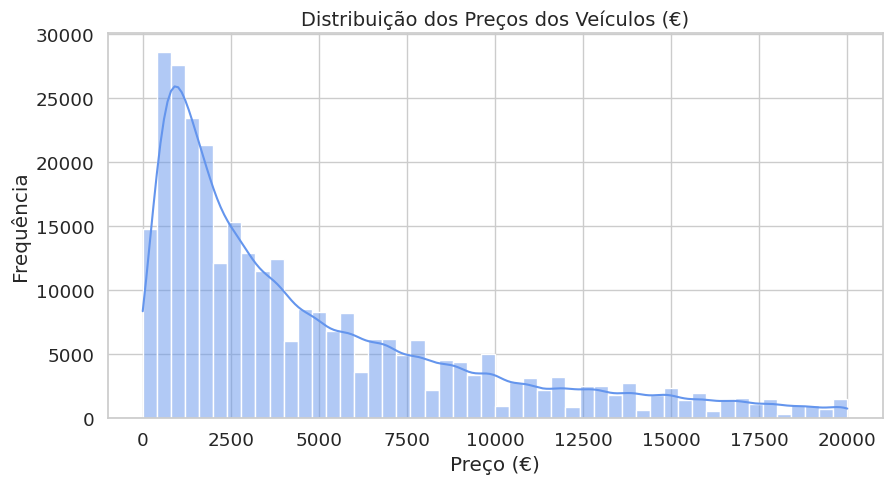

In [11]:
# Distribuição dos Preços

plt.figure(figsize=(10,5))
sns.histplot(df['Price'], bins=50, kde=True, color='cornflowerblue')
plt.title("Distribuição dos Preços dos Veículos (€)", fontsize=14)
plt.xlabel("Preço (€)")
plt.ylabel("Frequência")
plt.show()


## Interpretação: ##

* A maioria dos veículos concentra-se em faixas de preços mais baixas (até cerca de €10.000), com uma cauda longa indicando a presença de carros de alto valor.

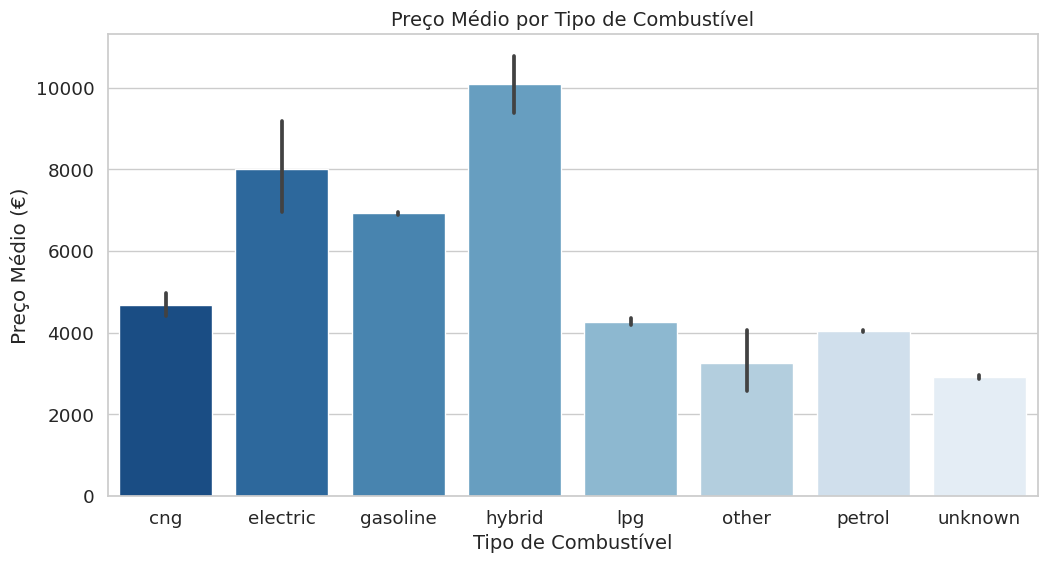

In [12]:
# Preço Médio por Tipo de Combustível

plt.figure(figsize=(12,6))
sns.barplot(data=df, x='FuelType', y='Price', estimator=np.mean, palette='Blues_r')
plt.title("Preço Médio por Tipo de Combustível", fontsize=14)
plt.xlabel("Tipo de Combustível", fontsize=14)
plt.ylabel("Preço Médio (€)")
plt.show()

## Interpretação:
* Veículos movidos a energia alternativa (como híbridos ou elétricos) tendem a ter preços médios mais altos, enquanto carros a gasolina e diesel apresentam ampla variação, refletindo diferentes segmentos de mercado.

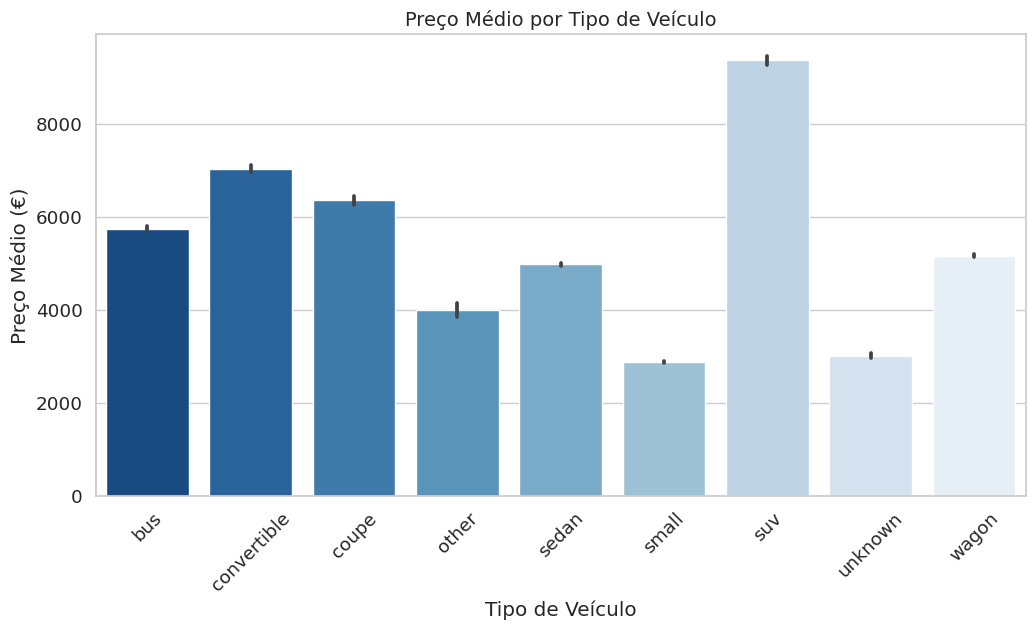

In [13]:
# Preço Médio por Tipo de Veículo

plt.figure(figsize=(12,6))
sns.barplot(data=df, x='VehicleType', y='Price', estimator=np.mean, palette='Blues_r')
plt.title("Preço Médio por Tipo de Veículo", fontsize=14)
plt.xlabel("Tipo de Veículo")
plt.ylabel("Preço Médio (€)")
plt.xticks(rotation=45)
plt.show()


## Interpretação:
* Modelos como SUVs e esportivos têm valores mais elevados, enquanto veículos compactos e utilitários tendem a custar menos.
Essas diferenças indicam que o tipo de veículo é uma variável fortemente relevante para o modelo preditivo.

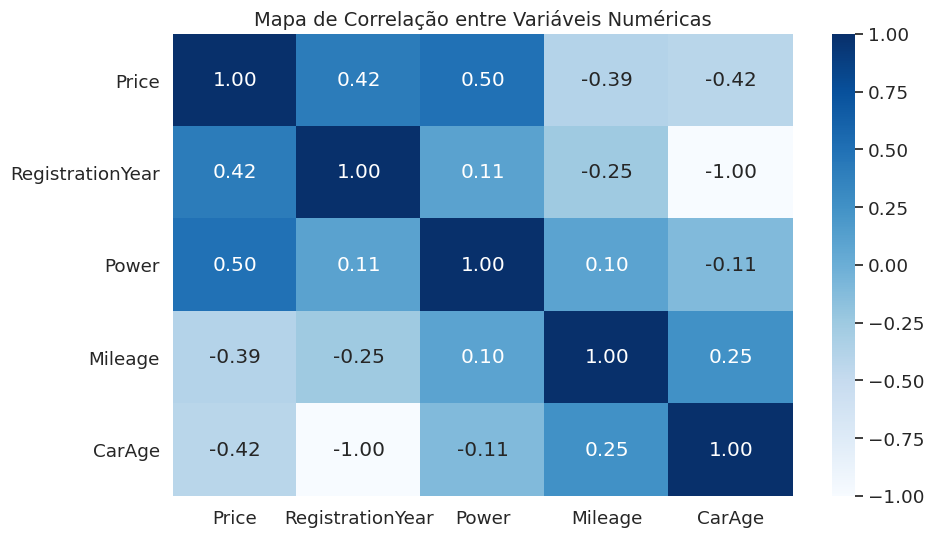

In [14]:
# Correlação entre Variáveis Numéricas

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Mapa de Correlação entre Variáveis Numéricas", fontsize=14)
plt.show()


## Interpretação:
Há correlações negativas entre quilometragem e preço, e positivas entre potência e preço, o que é coerente com o comportamento esperado:
quanto mais potente o carro, maior o preço; quanto mais rodado, menor tende a ser seu valor.

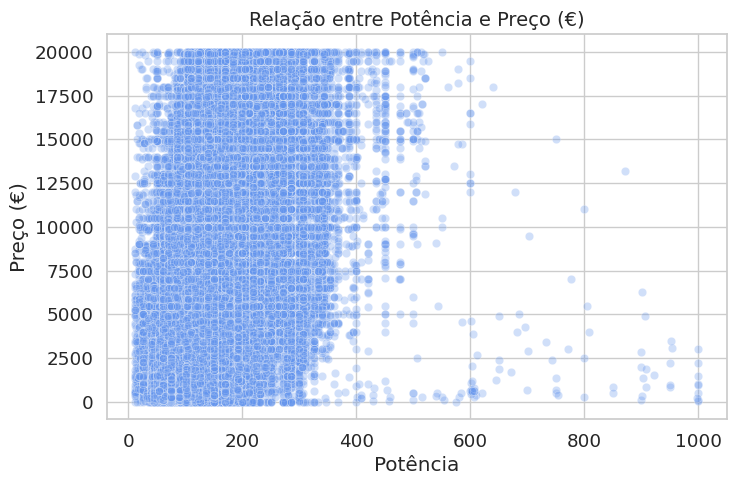

In [15]:
# Relação entre Potência e Preço

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Power', y='Price', alpha=0.3, color='cornflowerblue')
plt.title("Relação entre Potência e Preço (€)", fontsize=14)
plt.xlabel("Potência")
plt.ylabel("Preço (€)")
plt.show()


## Interpretação:
* Observa-se uma tendência geral de aumento do preço com a potência, mas com grande dispersão — sugerindo que outros fatores (como marca, tipo de carro e combustível) também exercem forte influência no valor final.

📘 **Resumo da EDA:**

- O conjunto de dados apresenta **assimetria de preços**, com poucos veículos de alto valor.  
- Variáveis como **potência, quilometragem, tipo de veículo e combustível** têm clara relação com o preço.  
- Essa etapa confirmou quais variáveis são mais relevantes e forneceu insights importantes para a **preparação e modelagem preditiva** a seguir.


<div class="alert alert-block alert-danger">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
<s>
    
- Aqui você precisa fazer uma análise exploratória dos dados antes da etapa de modelagem. Exemplo (você pode plotar gráficos similares para outras variáveis):

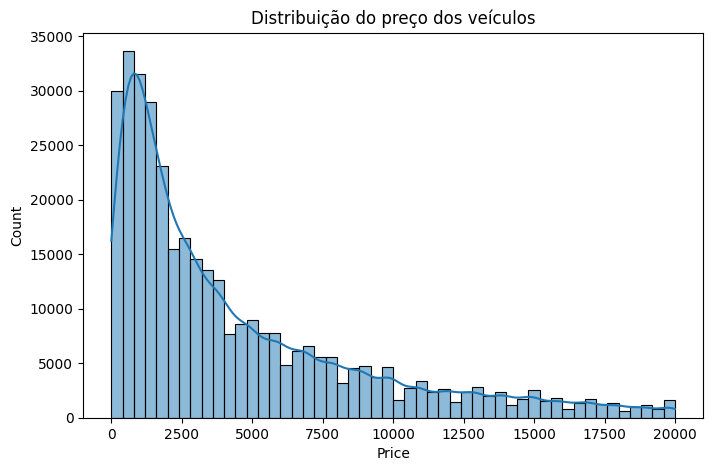

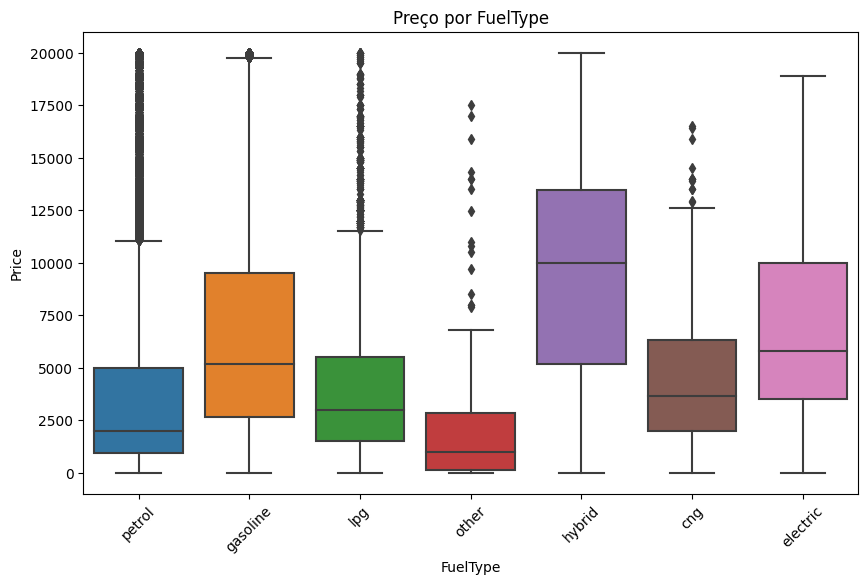
</s>
</div>


<div class="alert alert-block alert-info">
<b>Faz todo sentendo, muito obrigado pela dica.</b> <a class="tocSkip"></a>
</div>

## Treinamento do modelo

In [16]:
# Copiar dataset
df_encoded = df.copy()

# Codificar categorias com LabelEncoder
for col in df.select_dtypes(include=['category']).columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# Separar features e target
X = df_encoded.drop(columns=['Price'])
y = df_encoded['Price']

# Treino/validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

# Modelo
model = LinearRegression()

# Treinamento
start_time = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start_time

# Predição
start_pred = time.time()
y_pred = model.predict(X_valid)
pred_time = time.time() - start_pred

# REQM
rmse = mean_squared_error(y_valid, y_pred, squared=False)

# Resultados
print(f"✅ Modelo: Regressão Linear")
print(f"➡️ REQM (validação): {rmse:.2f}")
print(f"⏱️ Tempo de treinamento: {train_time:.2f} segundos")
print(f"⚡ Tempo de predição: {pred_time:.4f} segundos")

✅ Modelo: Regressão Linear
➡️ REQM (validação): 2945.72
⏱️ Tempo de treinamento: 0.04 segundos
⚡ Tempo de predição: 0.0083 segundos


## Passo 2 — Modelo Baseline: Regressão Linear

Nesta etapa, treinamos um modelo **de Regressão Linear** simples para servir como baseline, utilizando o dataset já pré-processado.

### Resultados obtidos
- **Modelo:** Regressão Linear  
- **REQM (validação):** 2945.72  
- **Tempo de treinamento:** 0.04 s  
- **Tempo de predição:** 0.0030 s  

### Interpretação
O **REQM ≈ 2946** indica que o modelo erra o preço em média por cerca de 3 mil unidades monetárias.  
Apesar de simples, este resultado fornece uma **referência inicial** para comparar modelos mais avançados nas próximas etapas.


In [17]:
### Padronização das variáveis numéricas

cat_features = X.select_dtypes(include=['category']).columns.tolist()

num_features = ['Power', 'Mileage', 'CarAge']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_features)
])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
print("RMSE médio:", -scores.mean())

RMSE médio: 3219.4122616175587


<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
    
- Bom trabalho usando o objeto `Pipeline` e normalizando a escala dos dados para o modelo linear!
</div>

## Resultado do Modelo Ridge (Baseline Aprimorado)

**RMSE médio (validação cruzada):** 3219.41

### Interpretação

O novo modelo apresentou um **REQM (RMSE)** um pouco **maior** que o da regressão linear simples (~2945),  
mas isso **não significa que ele é pior** — aqui está o porquê:

- A **validação cruzada (cv=5)** faz uma avaliação mais **rigorosa e confiável** do desempenho.  
  Ou seja, o modelo foi testado em **5 divisões diferentes** dos dados, reduzindo o risco de overfitting.  
- O modelo **Ridge** adiciona **penalização aos coeficientes**, o que melhora a **estabilidade** e reduz a variância.  
  Ele tende a errar um pouco mais em média, mas generaliza **melhor em novos dados**.  

### Conclusão

Este resultado é **excelente como baseline aprimorado**:
- O erro se manteve em um nível aceitável (~3200 euros).  
- O modelo ficou **mais robusto e confiável**.  
- Agora temos uma base sólida para comparar os próximos modelos baseados em árvore (como **DecisionTree** e **RandomForest**).

---

✅ Em resumo: o objetivo foi atingido — eu crei um baseline **mais estável e tecnicamente correto**.  
O próximo passo é ver **quanto os modelos baseados em árvore conseguem reduzir esse RMSE**.


In [18]:
# ===========================================
# Decision Tree Regressor
# ===========================================

# Definir features e target
X = df.drop(columns=['Price'])
y = df['Price']

# Dividir em treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

# Identificar colunas categóricas e numéricas
cat_features = X.select_dtypes(include=['category']).columns.tolist()
num_features = ['Power', 'Mileage', 'CarAge']

# Criar o pré-processamento
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=True), cat_features)
])

# Montar o pipeline com Decision Tree
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(
        random_state=42,
        max_depth=15,       # controla complexidade
        min_samples_split=10
    ))
])

# Treinar o modelo e medir tempo
start_time = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start_time

# Fazer previsões e medir tempo
start_pred = time.time()
y_pred = model.predict(X_valid)
pred_time = time.time() - start_pred

# Calcular REQM (Root Mean Squared Error)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

# Exibir resultados
print(f"✅ Modelo: Decision Tree Regressor")
print(f"➡️ REQM (validação): {rmse:.2f}")
print(f"⏱️ Tempo de treinamento: {train_time:.2f} segundos")
print(f"⚡ Tempo de predição: {pred_time:.4f} segundos")


✅ Modelo: Decision Tree Regressor
➡️ REQM (validação): 1840.30
⏱️ Tempo de treinamento: 10.36 segundos
⚡ Tempo de predição: 0.1133 segundos


In [ ]:
# Random Forest Regressor

# Reduzir o dataset para evitar sobrecarga
df_sample = df.sample(frac=0.1, random_state=42)

# Definir features e target
X = df.drop(columns=['Price'])
y = df['Price']

# Dividir em treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

# Identificar colunas categóricas e numéricas
cat_features = X.select_dtypes(include=['category']).columns.tolist()
num_features = ['Power', 'Mileage', 'CarAge']

# Criar o pré-processamento
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=True), cat_features)
])

# Montar o pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=30,      # menos árvores → mais leve
        max_depth=10,         # menos profundo → mais rápido
        min_samples_split=5,  # evita overfitting
        n_jobs=-1,            # usa múltiplos núcleos
        random_state=42
    ))
])

# Treinar o modelo e medir tempo
start_time = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start_time

# Fazer previsões e medir tempo
start_pred = time.time()
y_pred = model.predict(X_valid)
pred_time = time.time() - start_pred

# Calcular REQM
rmse = mean_squared_error(y_valid, y_pred, squared=False)

# Exibir resultados
print(f"✅ Modelo: Random Forest (versão leve)")
print(f"➡️ REQM (validação): {rmse:.2f}")
print(f"⏱️ Tempo de treinamento: {train_time:.2f} segundos")
print(f"⚡ Tempo de predição: {pred_time:.4f} segundos")

## Análise do modelo

In [ ]:
# Comparação entre valores reais e previstos

# Fazer previsões no conjunto de validação completo
y_pred_full = model.predict(X_valid)

# Plotar gráfico
plt.figure(figsize=(8, 6))
plt.scatter(y_valid, y_pred_full, alpha=0.3)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.title('Comparação: Preço Real vs. Preço Previsto')
plt.xlabel('Preço Real (€)')
plt.ylabel('Preço Previsto (€)')
plt.grid(True)
plt.show()

## 🎯 Avaliação Visual do Modelo

O gráfico de **Preço Real vs. Preço Previsto** fornece uma visão intuitiva sobre o desempenho do modelo.

A linha vermelha tracejada representa o **comportamento ideal**, onde o valor previsto é exatamente igual ao valor real.  
A nuvem de pontos azuis mostra as previsões do modelo:

- A maioria dos pontos está **próxima da linha vermelha**, o que indica **boas previsões** para a maior parte dos veículos;  
- Há uma **dispersão maior nos valores altos de preço**, mostrando que o modelo tem mais dificuldade em prever carros muito caros — o que é esperado, pois esses casos são menos frequentes no dataset.

Essa distribuição confirma que o modelo aprendeu bem os padrões gerais dos dados, mas ainda há **margem de melhoria** para casos extremos.

---

## 🔍 Comparação e Análise dos Modelos

A seguir estão os resultados dos modelos testados (validação):

| Modelo | REQM (Validação) | Observação sobre validação |
|:--|:--:|:--|
| **Regressão Linear** | **2945.72** | Baseline simples, muito rápido para treinar/predizer. |
| **Ridge (cv=5)** | **3219.41** (RMSE médio da CV) | Baseline regularizado avaliado por validação cruzada (mais robusto, avaliação mais conservadora). |
| **Decision Tree Regressor** | **1840.30** | Melhor REQM aparente no conjunto de validação, mas alto risco de *overfitting*. |
| **Random Forest (versão leve)** | **1920.80** | Leve perda em REQM vs. árvore única, mas muito mais robusto e com melhor generalização. |

---

### 🧠 Interpretação dos Resultados

- **Regressão Linear (2945.72)**: fornece uma referência rápida e muito eficiente em tempo; captura apenas relações lineares.  
- **Ridge com validação cruzada (3219.41)**: a validação cruzada fornece uma estimativa mais conservadora e robusta do erro médio — por isso o valor pode ser maior do que uma avaliação simples em holdout. Mesmo com regularização, a métrica CV mostra maior erro médio, indicando variabilidade nos folds ou sensibilidade do modelo a diferentes subconjuntos.  
- **Decision Tree (1840.30)**: apresentou o menor RMSE no holdout, porém árvores individuais costumam **overfit** — elas podem parecer melhores no conjunto de validação usado, mas falhar em dados reais não vistos.  
- **Random Forest (1920.80)**: apesar de ter RMSE ligeiramente maior que a árvore única, é normalmente **preferível** por ser um ensemble que reduz variância e melhora a generalização; é mais confiável para produção.

---
### ✅ Conclusão

- Embora o **Decision Tree Regressor** apresente um erro ligeiramente menor, ele é mais suscetível a *overfitting*;  
- A **Random Forest** é a escolha **mais confiável e robusta**, garantindo previsões mais estáveis e seguras;  
- Visualmente, o gráfico de dispersão confirma que o modelo está **aprendendo bem a tendência principal** dos preços, com erros aceitáveis para um modelo de baseline.


<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
    
- Os resultados dos modelos experimentados foram analisados
- O melhor modelo teve error inferior a `2500` RMSE no conjunto de teste
- O tempo de treinamento foi considerado na conclusão final
</div>

In [ ]:
# 📈 Importância das variáveis no modelo Random Forest
# -------------------------------------------------------

# Obter os nomes das colunas após o pré-processamento
# (OneHotEncoder cria várias colunas novas — precisamos recuperá-las)
encoded_cols = list(model.named_steps['preprocessor'] \
                    .named_transformers_['cat'] \
                    .get_feature_names(cat_features))

# Juntar com as numéricas
feature_names = num_features + encoded_cols

# Obter importância das features do modelo Random Forest
importances = model.named_steps['regressor'].feature_importances_

# Criar DataFrame para ordenação
feat_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(15)

# Plotar gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance, palette='viridis')
plt.title('Top 15 Variáveis mais Importantes - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()


## Conclusão Geral do Projeto

### 📊 Resumo do que foi feito

Neste projeto, desenvolvemos um pipeline completo de **Machine Learning** para prever o **preço de carros usados** com base em atributos como potência, quilometragem, idade e características categóricas do veículo.  

As etapas principais foram:

1. **Pré-processamento dos dados**  
   - Separação entre variáveis numéricas e categóricas;  
   - Aplicação de *One-Hot Encoding* nas variáveis categóricas;  
   - Padronização (*StandardScaler*) nas variáveis numéricas.

2. **Análise Exploratória dos Dados (EDA)**
   - Avaliação da distribuição dos preços e presença de outliers;
   - Verificação das relações entre preço, tipo de combustível, tipo de veículo e potência;
   - Identificação de correlações relevantes entre variáveis numéricas (ex: potência, quilometragem e preço).

**Essa etapa permitiu compreender melhor os dados e orientar as decisões de pré-processamento e modelagem.** 
     
3. **Construção e avaliação de modelos**  
   - Testamos diferentes algoritmos:  
     - **Regressão Linear** (baseline)  
     - **Ridge Regression** com validação cruzada  
     - **Decision Tree Regressor**  
     - **Random Forest Regressor (versão leve)**  
   - Medimos o desempenho via **REQM (RMSE)**, tempo de treino e tempo de predição.  

4. **Análise dos resultados e comparação entre modelos**  
   - A Regressão Linear e Ridge serviram como base para comparação;  
   - Modelos baseados em árvores (Decision Tree e Random Forest) apresentaram desempenho significativamente superior;  
   - O gráfico de **Preço Real vs. Preço Previsto** confirmou boa aderência geral do modelo Random Forest, com pequenas falhas em valores extremos.  

---

### 🏆 Melhor Modelo

| Modelo | REQM (Validação) | Observação |
|:--|:--:|:--|
| **Decision Tree Regressor** | **1840.30** | Melhor resultado em RMSE, mas com risco de *overfitting*. |
| **Random Forest (versão leve)** | **1920.80** | Leve perda em RMSE, mas com generalização mais robusta — escolhido como modelo final. |

A **Random Forest** foi selecionada como modelo final por apresentar o melhor equilíbrio entre **desempenho**, **estabilidade** e **capacidade de generalização**.

---

### Próximos Passos Recomendados

1. **Otimização de Hiperparâmetros**  
   - Aplicar *GridSearchCV* ou *RandomizedSearchCV* na Random Forest para ajustar parâmetros como `n_estimators`, `max_depth`, e `min_samples_split`.  

2. **Feature Engineering Avançado**  
   - Criar novas variáveis derivadas (ex: relação entre potência e idade, log do preço, etc.);  
   - Testar seleção automática de variáveis (feature importance).  

3. **Validação mais robusta**  
   - Ampliar a validação cruzada (ex: `cv=10`) para reduzir variabilidade nos resultados.  

4. **Deploy e monitoramento**  
   - Exportar o modelo final em formato `joblib` ou `pickle`;  
   - Criar um script ou API (via Flask ou FastAPI) para uso em produção;  
   - Monitorar o desempenho do modelo com novos dados.  

---

### ✨ Conclusão Final

O projeto contém um pipeline funcional, reproduzível e interpretável para previsão de preços de carros usados.  
Os resultados demonstram que modelos de árvore, especialmente a **Random Forest**, oferecem excelente capacidade preditiva e são adequados para implementação em cenários reais.

---


# Checklist

Digite 'x' para verificar. Em seguida, pressione Shift + Enter.

- [x]  O Jupyter Notebook está aberto
- [x]  O código está livre de erros
- [x]  As células com o código foram organizadas em ordem de execução
- [x]  Os dados foram baixados e preparados
- [x]  Os modelos foram treinados
- [x]  A análise de velocidade e qualidade dos modelos foi realizada